## Model Tuning and Validation

In [38]:
# Import resources
import pandas as pd
import xgboost
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,\
ExtraTreesClassifier, VotingClassifier, StackingRegressor, AdaBoostClassifier
from sklearn.metrics import recall_score, f1_score, plot_roc_curve, plot_confusion_matrix, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [7]:
# Read in the data sets from main notebook
X_train = pd.read_csv("data/X_train.csv").set_index('Unnamed: 0')
X_test = pd.read_csv("data/X_test.csv").set_index('Unnamed: 0')
y_train = pd.read_csv("data/y_train.csv").set_index('Unnamed: 0')
y_test = pd.read_csv("data/y_test.csv").set_index('Unnamed: 0')

In [8]:
# Drop features with multicolinearity discovered in main notebook
X_train = X_train.drop(columns=['first_tri_daily_cig', 'second_tri_daily_cig',
       'third_tri_daily_cig', 'infertility_treatment'])
X_test = X_test.drop(columns=['first_tri_daily_cig', 'second_tri_daily_cig',
       'third_tri_daily_cig', 'infertility_treatment'])

## Generate Preprocessed Array for Grid Searching

In [9]:
# Data preprocessing column transformer
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(
    steps=[("num_imputer", SimpleImputer(strategy="median")), ("scaler", MinMaxScaler())]
)

categorical_features = X_train.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(
    steps=[("cat_imputer", SimpleImputer(strategy="most_frequent")), ("ohe", OneHotEncoder(handle_unknown = 'ignore'))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [10]:
# Generate preprocessed data
preproc = Pipeline(
    steps=[("preprocessor", preprocessor)]
)

X_train_proc = preproc.fit_transform(X_train)
X_test_proc = preproc.transform(X_test)

In [11]:
X_train_proc.shape

(20000, 67)

## Logistic Regression

In [12]:
logpipe = Pipeline([
    ('logistic', LogisticRegression())
])

# Parameters for the grid search
parameters = {
    'logistic__C': [1000], # Tried: 1, 10, 100, 1000, 10,000
    'logistic__max_iter': [1000],
    'logistic__fit_intercept': [True], # Tried: False
    'logistic__random_state': [27],
    'logistic__solver': ['sag'], # Tried: saga, lbfgs
    'logistic__n_jobs': [4]
}

# Perform grid search prioritizing precision
grid_log = GridSearchCV(logpipe, param_grid=parameters, scoring='recall')

# Fit grid search and predict
grid_log.fit(X_train_proc, y_train.values.ravel())

print(grid_log.best_score_)
print(grid_log.best_params_)

# Confusion matrix for the logistic model
fig, ax = plt.subplots()

fig.suptitle("Logistic Model")

plot_confusion_matrix(grid_log, X_test_proc, y_test, ax=ax, values_format='');

0.5711999999999999
{'logistic__C': 1000, 'logistic__fit_intercept': True, 'logistic__max_iter': 1000, 'logistic__n_jobs': 4, 'logistic__random_state': 27, 'logistic__solver': 'sag'}


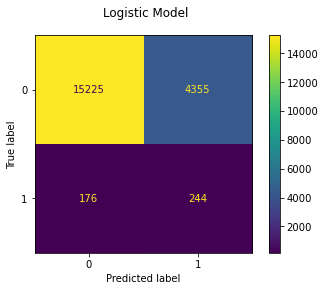

In [15]:
# Confusion matrix for the logistic model
fig, ax = plt.subplots()

fig.suptitle("Logistic Model")

plot_confusion_matrix(grid_log, X_test_proc, y_test, ax=ax, values_format='');

## KNNeighbors Classifier

In [18]:
knnpipe = Pipeline([
    ('knn', KNeighborsClassifier())
])

# Parameters for the grid search
parameters = {
    'knn__n_neighbors': [5], # Tried: 2-10
    'knn__leaf_size': [10], # Tried: 5-100
    'knn__n_jobs': [4]
}

# Perform grid search prioritizing precision
grid_knn = GridSearchCV(knnpipe, param_grid=parameters, scoring='recall')

# Fit grid search and predict
grid_knn.fit(X_train_proc, y_train.values.ravel())

print(grid_knn.best_score_)
print(grid_knn.best_params_)

# Confusion matrix for the KNN model
fig, ax = plt.subplots()

fig.suptitle("KNN Model")

plot_confusion_matrix(grid_knn, X_test_proc, y_test, ax=ax, values_format='');

0.5334000000000001
{'knn__leaf_size': 10, 'knn__n_jobs': 4, 'knn__n_neighbors': 5}


## Decision Tree Classifier

0.6046
{'tree__criterion': 'gini', 'tree__max_depth': 30, 'tree__min_samples_leaf': 30, 'tree__min_samples_split': 2, 'tree__random_state': 27}


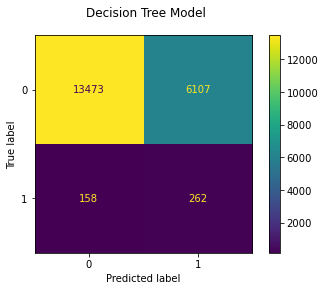

In [17]:
treepipe = Pipeline([
    ('tree', DecisionTreeClassifier())
])

# Parameters for the grid search
parameters = {
    'tree__criterion': ['gini'], # Tried: entropy
    'tree__max_depth': [30], # Tried: 2-40
    'tree__min_samples_split': [2], # Tried: 2-50
    'tree__min_samples_leaf': [30], # Tried: 2-300
    'tree__random_state': [27]
}

# Perform grid search prioritizing precision
grid_tree = GridSearchCV(treepipe, param_grid=parameters, scoring='recall')

# Fit grid search and predict
grid_tree.fit(X_train_proc, y_train.values.ravel())

print(grid_tree.best_score_)
print(grid_tree.best_params_)

# Confusion matrix for the Tree model
fig, ax = plt.subplots()

fig.suptitle("Decision Tree Model")

plot_confusion_matrix(grid_tree, X_test_proc, y_test, ax=ax, values_format='');

## Random Forest

0.6058
{'forest__criterion': 'gini', 'forest__max_depth': 50, 'forest__min_samples_leaf': 2, 'forest__min_samples_split': 10, 'forest__n_estimators': 5, 'forest__n_jobs': 4, 'forest__random_state': 27}


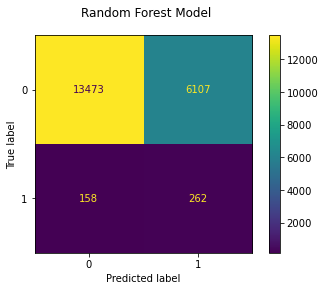

In [21]:
forestpipe = Pipeline([
    ('forest', RandomForestClassifier())
])

# Parameters for the grid search
parameters = {
    'forest__n_estimators': [5], # Tried: 2-300
    'forest__criterion': ['gini'], # Tried: entropy
    'forest__min_samples_split': [10], # Tried: 2-20
    'forest__min_samples_leaf': [2], # Tried: 2-50
    'forest__max_depth': [50], # Tried: 2-60
    'forest__n_jobs': [4],
    'forest__random_state': [27]
}

# Perform grid search prioritizing precision
grid_forest = GridSearchCV(forestpipe, param_grid=parameters, scoring='recall')

# Fit grid search and predict
grid_forest.fit(X_train_proc, y_train.values.ravel())

print(grid_forest.best_score_)
print(grid_forest.best_params_)

# Confusion matrix for the Forest model
fig, ax = plt.subplots()

fig.suptitle("Random Forest Model")

plot_confusion_matrix(grid_forest, X_test_proc, y_test, ax=ax, values_format='');

## XGBoost

0.6174000000000001
{'boost__gamma': 1, 'boost__max_depth': 19, 'boost__min_child_weight': 27, 'boost__n_estimators': 125, 'boost__random_state': 27}


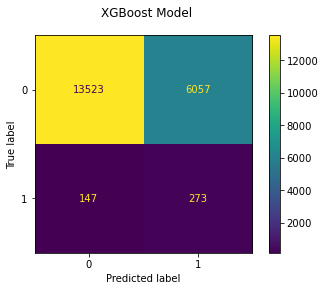

In [31]:
boostpipe = Pipeline([
    ('boost', xgboost.XGBClassifier())
])

# Parameters for grid search
parameters = {
    'boost__max_depth': [19], # Tried: 2-50
    'boost__min_child_weight': [27], # Tried: 1-50
    'boost__gamma': [1], # Tried: 0.5-200
    'boost__n_estimators': [125], # Tried: 5-75
    'boost__random_state': [27]
}

# Grid search with boost model
grid_boost = GridSearchCV(boostpipe, param_grid=parameters, scoring='recall')

# Fit model and generate predictions
grid_boost.fit(X_train_proc, y_train.values.ravel())

print(grid_boost.best_score_)
print(grid_boost.best_params_)

# Confusion matrix for the XGBoost model
fig, ax = plt.subplots()

fig.suptitle("XGBoost Model")

plot_confusion_matrix(grid_boost, X_test_proc, y_test, ax=ax, values_format='');

0.7458
{'ada__learning_rate': 2, 'ada__n_estimators': 30, 'ada__random_state': 27}


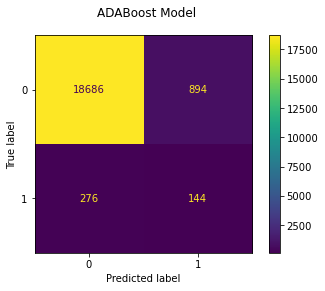

In [35]:
adapipe = Pipeline([
    ('ada', AdaBoostClassifier())
])

# Parameters for grid search
parameters = {
    'ada__n_estimators': [30], # Tried: 2-50
    'ada__learning_rate': [2], # Tried: 0.5-5
    'ada__random_state': [27]
}

# Grid search with boost model
grid_ada = GridSearchCV(adapipe, param_grid=parameters, scoring='recall')

# Fit model and generate predictions
grid_ada.fit(X_train_proc, y_train.values.ravel())

print(grid_ada.best_score_)
print(grid_ada.best_params_)

# Confusion matrix for the XGBoost model
fig, ax = plt.subplots()

fig.suptitle("ADABoost Model")

plot_confusion_matrix(grid_ada, X_test_proc, y_test, ax=ax, values_format='');

## Summary

Overall, the ADABoost model produced the highest recall score. However, I believe the appropriate model to finalize would be the XGBoost model. ADABoost was much more effective at labeling the true negatives (predicting healthy babies will be healthy) but significantly worse than the other top contenders at true positives (predicting unhealthy babies will be unhealthy). 

In order to further optimize the models, one avenue of interest could be designing a custom scoring function that strike a balance between the class of interest and the majority class.